In [1]:
import pandas as pd
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Data Preprocessing

In [2]:
constructors_df = pd.read_csv('data/constructors.csv')
drivers_df = pd.read_csv('data/drivers.csv')
races_df = pd.read_csv('data/races.csv')
results_df = pd.read_csv('data/results.csv')

In [3]:
filtered_races_df = races_df[races_df['year'] >= 1982]
filtered_races_df = filtered_races_df[['raceId', 'circuitId', 'year', 'round']]
sorted_races_df = filtered_races_df.sort_values(by='year')

In [4]:
selected_results_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]
merged_df = sorted_races_df.merge(selected_results_df, on='raceId')

In [5]:
selected_drivers_df = drivers_df[['driverId', 'driverRef']]
merged_df = merged_df.merge(selected_drivers_df, on='driverId', how='left')

In [6]:
selected_constructor_df = constructors_df[['constructorId', 'name']].rename(columns={'name': 'constructorName'})
merged_df = merged_df.merge(selected_constructor_df, on='constructorId', how='left')

In [7]:
df = merged_df

#### Feature Engineering

In [8]:
df['podium_finish'] = np.where(df['positionOrder'] <= 3, 1, 0)
df.head()

,raceId,circuitId,year,round,driverId,constructorId,grid,positionOrder,driverRef,constructorName,podium_finish
0,472,6,1982,6,119,34,2,1,patrese,Brabham,1
1,472,6,1982,6,202,6,5,2,pironi,Ferrari,1
2,472,6,1982,6,110,51,7,3,cesaris,Alfa Romeo,1
3,472,6,1982,6,95,32,11,4,mansell,Team Lotus,0
4,472,6,1982,6,173,32,15,5,angelis,Team Lotus,0


In [9]:
# Group by 'driverRef' and 'year' to compute total races and total podium finishes
driver_year_stats = df.groupby(['driverId', 'year']).agg(
    total_races=('raceId', 'nunique'),
    total_podiums=('podium_finish', 'sum'),
    avg_position=('positionOrder', 'mean')
).reset_index()

# Compute the percentage of podium finishes for each driver for the previous year
driver_year_stats['prev_year'] = driver_year_stats['year'] + 1
driver_year_stats['podium_percentage'] = (driver_year_stats['total_podiums'] / driver_year_stats['total_races']) * 100

# Merge this information back into the original DataFrame
df = df.merge(driver_year_stats[['driverId', 'prev_year', 'podium_percentage', 'avg_position']],
                            left_on=['driverId', 'year'],
                            right_on=['driverId', 'prev_year'],
                            how='left')

# Rename the column for clarity
df = df.rename(columns={
    'podium_percentage': 'driver_prev_season_podium_pct',
    'avg_position': 'driver_prev_season_avg_position'
})

# Drop the 'prev_year' column as it's no longer needed
df = df.drop(columns=['prev_year'])

In [10]:
# Group by 'driverId', 'year', and 'round' to compute total races and total podium finishes up to the current round
df['cumulative_races'] = df.groupby(['driverId', 'year'])['raceId'].cumcount() + 1
df['cumulative_podiums'] = df.groupby(['driverId', 'year'])['podium_finish'].cumsum()
df['cumulative_position_sum'] = df.groupby(['driverId', 'year'])['positionOrder'].cumsum()

# Compute the percentage of podium finishes for each driver up to the current round
df['driver_cumulative_podium_pct'] = (df['cumulative_podiums'] / df['cumulative_races']) * 100
df['driver_cumulative_avg_position'] = df['cumulative_position_sum'] / df['cumulative_races']

# Drop the columns that are no longer needed
df = df.drop(columns=['cumulative_races', 'cumulative_podiums', 'cumulative_position_sum'])

In [11]:
# Group by 'constructorId' and 'year' to compute total races and total podium finishes
constructor_year_stats = df.groupby(['constructorId', 'year']).agg(
    total_races=('raceId', 'nunique'),
    total_podiums=('podium_finish', 'sum'),
    avg_position=('positionOrder', 'mean')
).reset_index()

# Double the number of races for each constructor to account for the two drivers
constructor_year_stats['total_races'] = constructor_year_stats['total_races'] * 2

# Compute the percentage of podium finishes for each constructor for the previous year
constructor_year_stats['prev_year'] = constructor_year_stats['year'] + 1
constructor_year_stats['podium_percentage'] = (constructor_year_stats['total_podiums'] / constructor_year_stats['total_races']) * 100

# Merge this information back into the original DataFrame
df = df.merge(constructor_year_stats[['constructorId', 'prev_year', 'podium_percentage', 'avg_position']],
                            left_on=['constructorId', 'year'],
                            right_on=['constructorId', 'prev_year'],
                            how='left')

# Rename the column for clarity
df = df.rename(columns={
    'podium_percentage': 'constructor_prev_season_podium_pct',
    'avg_position': 'constructor_prev_season_avg_position'
})

# Drop the 'prev_year' column as it's no longer needed
df = df.drop(columns=['prev_year'])

In [12]:
# Group by 'constructorId', 'year', and 'round' to compute total races and total podium finishes up to the current round
df['cumulative_races'] = df.groupby(['constructorId', 'year'])['raceId'].cumcount() + 1
df['cumulative_podiums'] = df.groupby(['constructorId', 'year'])['podium_finish'].cumsum()
df['cumulative_position_sum'] = df.groupby(['constructorId', 'year'])['positionOrder'].cumsum()

# Compute the percentage of podium finishes for each constructor up to the current round
df['constructor_cumulative_podium_pct'] = (df['cumulative_podiums'] / df['cumulative_races']) * 100
df['constructor_cumulative_avg_position'] = df['cumulative_position_sum'] / df['cumulative_races']

# Drop the columns that are no longer needed
df = df.drop(columns=['cumulative_races', 'cumulative_podiums', 'cumulative_position_sum'])

In [13]:
df = df.drop(columns=['raceId', 'positionOrder'])
df = df.dropna()

#### Exploration

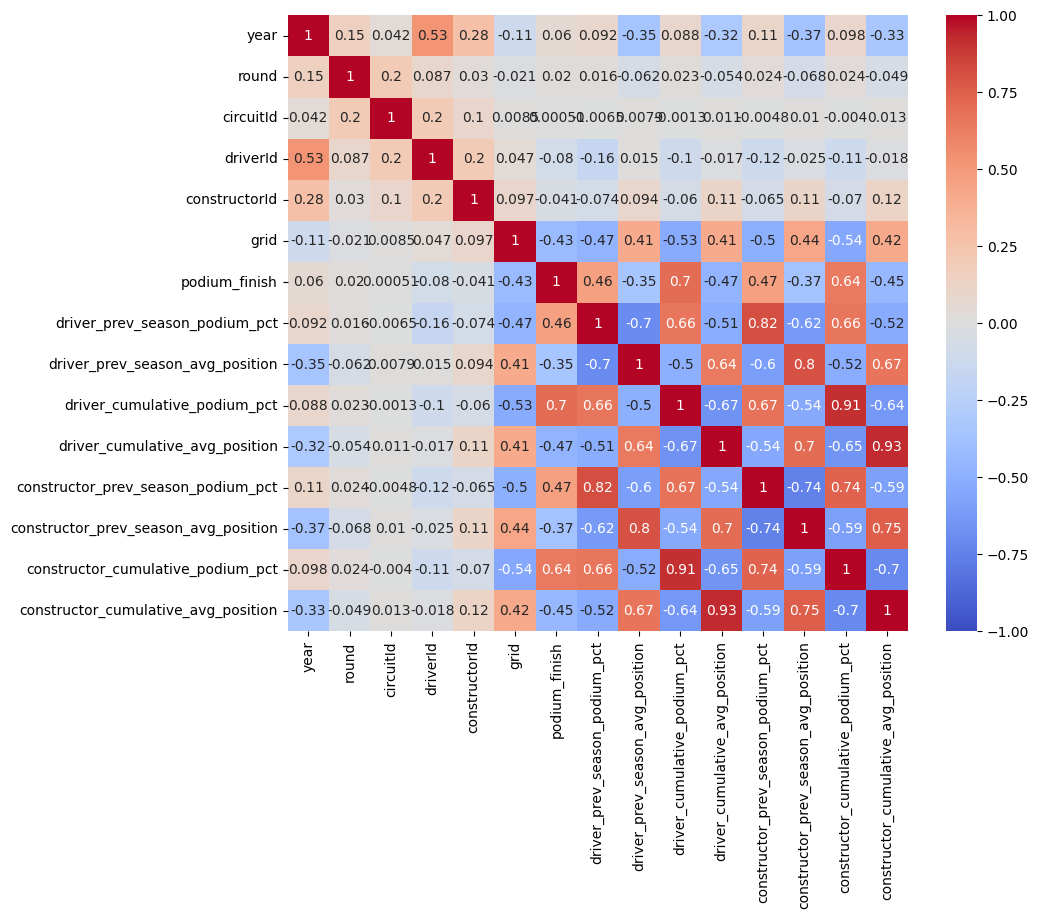

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df[['year', 'round', 'circuitId', 'driverId', 'constructorId', 'grid', 'podium_finish',
              'driver_prev_season_podium_pct', 'driver_prev_season_avg_position', 'driver_cumulative_podium_pct',
              'driver_cumulative_avg_position', 'constructor_prev_season_podium_pct', 'constructor_prev_season_avg_position',
              'constructor_cumulative_podium_pct', 'constructor_cumulative_avg_position']].copy()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [15]:
df_encoded = pd.get_dummies(df, columns=['circuitId', 'driverId', 'constructorId']).drop(columns=['driverRef', 'constructorName'])

#### Model Training / Validation

In [16]:
train_df = df_encoded[(df_encoded["year"] >= 1983) & (df_encoded["year"] <= 2008)]
val_df = df_encoded[(df_encoded["year"] >= 2009) & (df_encoded["year"] <= 2016)]
test_df = df_encoded[(df_encoded["year"] >= 2017) & (df_encoded["year"] <= 2023)]

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Define features and target
X_train = train_df.drop(columns=['podium_finish'])
y_train = train_df['podium_finish']
X_val = val_df.drop(columns=['podium_finish'])
y_val = val_df['podium_finish']
X_test = test_df.drop(columns=['podium_finish'])
y_test = test_df['podium_finish']

# Define parameter grids for each model
param_grid_knn = {
    'n_neighbors': [7, 9, 11],
    'weights': ['uniform', 'distance']
}

param_grid_svc = {
    'C': [0.01, 0.1, 1],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth': [2, 4, 6],
    'criterion': ['gini', 'entropy']
}

# Initialize models
knn = KNeighborsClassifier()
svc = SVC()
rf = RandomForestClassifier()

# Perform grid search for each model
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='f1')
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, scoring='f1')
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1')

# Train models
grid_search_knn.fit(X_train, y_train)
grid_search_svc.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)

# Evaluate models on validation data
y_val_pred_knn = grid_search_knn.predict(X_val)
y_val_pred_svc = grid_search_svc.predict(X_val)
y_val_pred_rf = grid_search_rf.predict(X_val)

# Print best parameters and classification reports
print("K-Nearest Neighbors Classifier:")
print("Best Parameters:", grid_search_knn.best_params_)
print(classification_report(y_val, y_val_pred_knn))

print("\nSupport Vector Machine Classifier:")
print("Best Parameters:", grid_search_svc.best_params_)
print(classification_report(y_val, y_val_pred_svc))

print("\nRandom Forest Classifier:")
print("Best Parameters:", grid_search_rf.best_params_)
print(classification_report(y_val, y_val_pred_rf))

K-Nearest Neighbors Classifier:
Best Parameters: {'n_neighbors': 11, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2003
           1       0.71      0.64      0.67       430

    accuracy                           0.89      2433
   macro avg       0.82      0.79      0.80      2433
weighted avg       0.89      0.89      0.89      2433


Support Vector Machine Classifier:
Best Parameters: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2003
           1       0.73      0.68      0.70       430

    accuracy                           0.90      2433
   macro avg       0.83      0.81      0.82      2433
weighted avg       0.90      0.90      0.90      2433


Random Forest Classifier:
Best Parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'n_estimators': 200}
              precision    recall

#### Model Evaluation

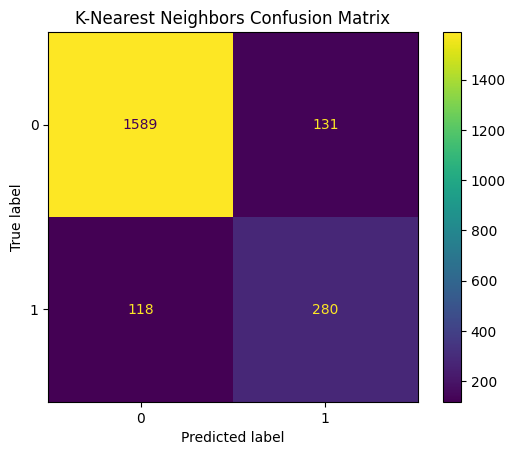

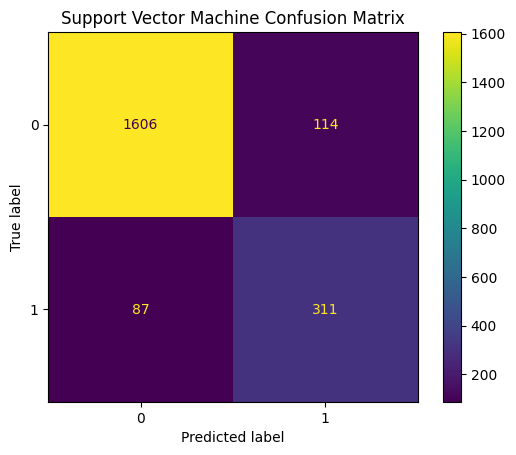

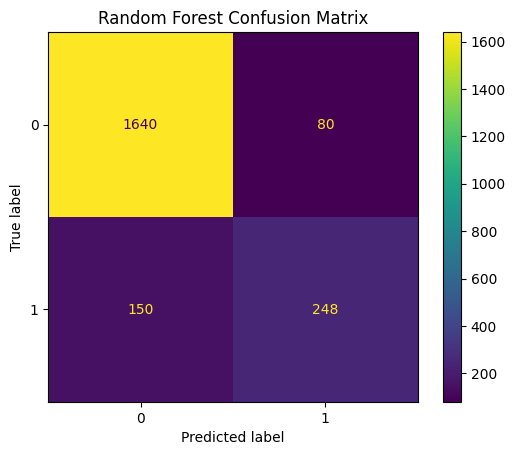

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluate models on test data
y_test_pred_knn = grid_search_knn.predict(X_test)
y_test_pred_svc = grid_search_svc.predict(X_test)
y_test_pred_rf = grid_search_rf.predict(X_test)

# Print confusion matrices
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_knn)
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_svc)
plt.title("Support Vector Machine Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()

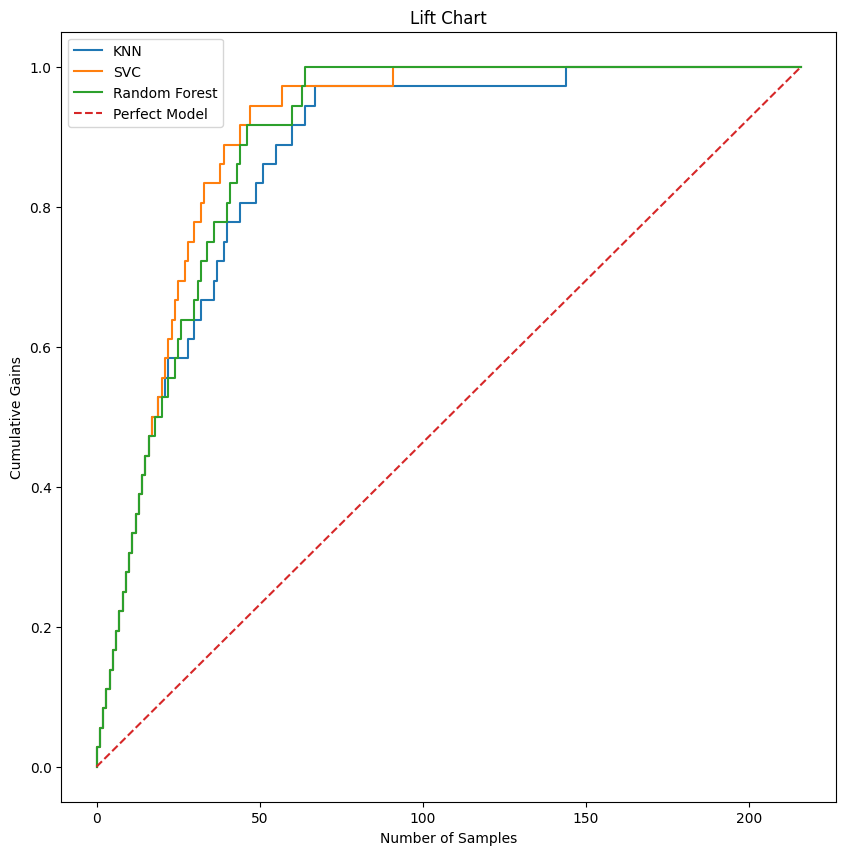

In [21]:
# Filter the test set by year 2023
test_df_2023 = test_df[test_df['year'] == 2023]

# Extract features and target
X_test_2023 = test_df_2023.drop(columns=['podium_finish'])
y_test_2023 = test_df_2023['podium_finish']

# Create and fit the model with probability=True
svc_prob_true = SVC(**grid_search_svc.best_params_, probability=True)
svc_prob_true.fit(X_train, y_train)

# Predict probabilities for each model
knn_probs = grid_search_knn.best_estimator_.predict_proba(X_test_2023)[:, 1]
svc_probs = svc_prob_true.predict_proba(X_test_2023)[:, 1]
rf_probs = grid_search_rf.best_estimator_.predict_proba(X_test_2023)[:, 1]

# Function to calculate cumulative gains
def calculate_cumulative_gains(probs, y_true):
    sorted_indices = np.argsort(probs)[::-1]
    sorted_y_true = y_true.iloc[sorted_indices]
    cumulative_gains = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)
    return np.concatenate([[0], cumulative_gains])

# Calculate cumulative gains for each model
knn_cumulative_gains = calculate_cumulative_gains(knn_probs, y_test_2023)
svc_cumulative_gains = calculate_cumulative_gains(svc_probs, y_test_2023)
rf_cumulative_gains = calculate_cumulative_gains(rf_probs, y_test_2023)

# Plot lift chart
fig = plt.figure(figsize=(10, 10))
plt.step(range(len(knn_cumulative_gains)), knn_cumulative_gains, label='KNN')
plt.step(range(len(svc_cumulative_gains)), svc_cumulative_gains, label='SVC')
plt.step(range(len(rf_cumulative_gains)), rf_cumulative_gains, label='Random Forest')

# Plot perfect model
perfect_model = np.linspace(0, 1, len(y_test_2023) + 1)
plt.plot(range(len(perfect_model)), perfect_model, label='Perfect Model', linestyle='--')

plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Gains')
plt.title('Lift Chart')
plt.legend()
plt.show()

In [20]:
# Extract feature importances from the trained RandomForestClassifier
feature_importances = grid_search_rf.best_estimator_.feature_importances_

# Create a DataFrame to associate feature names with their importances
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print the top 10 features
print("Top 10 Feature Importances:")
print(features_df.head(10))

Top 10 Feature Importances:
                          Feature  Importance
5    driver_cumulative_podium_pct         1.0
0                            year         0.0
198                  driverId_187         0.0
205                  driverId_807         0.0
204                  driverId_197         0.0
203                  driverId_196         0.0
202                  driverId_195         0.0
201                  driverId_192         0.0
200                  driverId_190         0.0
199                  driverId_188         0.0
